In [11]:
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import InceptionResNetV2, VGG19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dropout, concatenate, Dense, Average, Dot
from tensorflow.keras.layers import MaxPool2D, Conv2D, Add, ReLU, Lambda
from tensorflow.keras.layers import Input, Flatten, BatchNormalization


from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from config import *
from time import time
import configparser
from datetime import date
import statistics
import os

In [2]:
# for apex - onset
# emotion_data = pd.read_csv('./database/segmented_parts.csv')
# images_lefteye, labels_lefteye = generateDataset(emotion_data, '_left_eye')
# images_righteye, labels_righteye = generateDataset(emotion_data, '_right_eye')
# images_mouth, labels_mouth = generateDataset(emotion_data, '_mouth')
# images_face, labels_face = generateDataset(emotion_data, '')

In [3]:
# for 1 * 1 vImages
lefteye_vImages = np.load('./vImages/leftEye1.npz')
left_images = np.array(lefteye_vImages['images'])
left_labels = np.array(lefteye_vImages['labels'])
righteye_vImages = np.load('./vImages/rightEye1.npz')
right_images = np.array(righteye_vImages['images'])
right_labels = np.array(righteye_vImages['labels'])
mouth_vImages = np.load('./vImages/mouth1.npz')
mn_images = np.array(mouth_vImages['images'])
mn_labels = np.array(mouth_vImages['labels'])
face_vImages = np.load('./vImages/face1.npz')
whole_images = np.array(face_vImages['images'])
whole_labels = np.array(face_vImages['labels'])

In [2]:
# for 3 * 3 videos
lefteye_videos = np.load('./videos_sq3/leftEye.npz')
left_videos = np.array(lefteye_videos['videos'])
left_labels = np.array(lefteye_videos['labels'])
righteye_videos = np.load('./videos_sq3/rightEye.npz')
right_videos = np.array(righteye_videos['videos'])
right_labels = np.array(righteye_videos['labels'])
mouth_videos = np.load('./videos_sq3/mouth.npz')
mn_videos = np.array(mouth_videos['videos'])
mn_labels = np.array(mouth_videos['labels'])
face_videos = np.load('./videos_sq3/face.npz')
whole_videos = np.array(face_videos['videos'])
whole_labels = np.array(face_videos['labels'])

In [2]:
# for 1 * 1 videos
lefteye_videos = np.load('./videos_sq1/leftEye.npz')
left_videos = np.array(lefteye_videos['videos'])
left_labels = np.array(lefteye_videos['labels'])
righteye_videos = np.load('./videos_sq1/rightEye.npz')
right_videos = np.array(righteye_videos['videos'])
right_labels = np.array(righteye_videos['labels'])
mouth_videos = np.load('./videos_sq1/mouth.npz')
mn_videos = np.array(mouth_videos['videos'])
mn_labels = np.array(mouth_videos['labels'])
face_videos = np.load('./videos_sq1/face.npz')
whole_videos = np.array(face_videos['videos'])
whole_labels = np.array(face_videos['labels'])

In [3]:
# for images
def runFile(configFileName):

    configFile = configparser.ConfigParser()
    configFile.read(configFileName)
    epoch_num = 50
    
    # parameters
    square_size = int(configFile['param']['square size'])
    output_dense = int(configFile['param']['output of dense layer'])
    output_firstLayer = int(configFile['param']['output of first layer'])
    output_secondLayer = int(configFile['param']['output of second layer'])
    seed = int(configFile['param']['seed'])
#     print(type(output_dense))
    
    # four landmarks
    databaseNames = ['lefteye', 'righteye', 'mouth&nose', 'face']
    datasets = [[left_images, left_labels], 
            [right_images, right_labels], 
            [mn_images, mn_labels], 
            [whole_images, whole_labels]]
    
#     #     [5, 10, 20, 40]
#     output_dense = 10
#     #     [8, 16, 32]
#     output_firstLayer = 8
#     #     [16, 32, 64]
#     output_secondLayer = 16
    
    for j in range(4):
        databaseName = databaseNames[j]
        databaseType = 'vImage'
        dataset = datasets[j]
        images = dataset[0]
        labels = dataset[1]
    #     print(images.shape)
        model = build_SimpleNet(input_shape=(images.shape[1], images.shape[2], 1), output_shape=5, 
                                outputsize_firstLayer = output_firstLayer, outputsize_secondLayer = output_secondLayer, 
                                outputsize_dense = output_dense)
    #     new_output = Dense(5, activation='softmax')(model.output)
    #     model = Model(inputs = [model.input], outputs = new_output)
        np.random.seed(seed)
    #     print(1)
        perm = np.random.permutation(images.shape[0])
        images = images[perm]
        labels = labels[perm]

        images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size = 0.2, random_state = seed)

        images_train.resize(np.append(images_train.shape, [1]))
        checkpt = ModelCheckpoint(filepath="simplest_network.h5",
                                      verbose=2,
                                      save_best_only=True,
                                      monitor='val_accuracy')

        model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',  #(learning_rate=0.00005)',
               metrics=['accuracy'])


        start_time = time()
        model_log = model.fit(images_train, labels_train,
                              validation_split = 0.2,
                              epochs = epoch_num,
                              shuffle = True,
                              callbacks = [checkpt])

        end_time = time()

        images_test.resize(np.append(images_test.shape, [1]))

        model_best = load_model('simplest_network.h5')
        loss_train,acc_train = model_best.evaluate(images_train,labels_train,verbose=0)
        loss_test,acc_test = model_best.evaluate(images_test,labels_test,verbose=0)
        print('landmark: ', j, 'epoch: ', epoch_num)
        print()
        print('train loss',loss_train.round(3))
        print(' test loss',loss_test.round(3))
        print()
        print('train accuracy',acc_train.round(2))
        print(' test accuracy',acc_test.round(2))
        print()
        print('time', (end_time - start_time) / 60)
        
        config = configparser.ConfigParser()
        config['param'] = configFile['param']
        config['info'] = {'databaseName' : databaseName,
                         'dataType' : databaseType,
                         'params' : model_log.params,
                         'time' : (end_time - start_time) / 60}
        config['result'] = {'validation_accuracy' : np.array(model_log.history['val_accuracy']).max(),
                           'train loss' : loss_train.round(3),
                           'test loss' : loss_test.round(3),
                           'train accuracy' : acc_train.round(3),
                           'test accuracy' : acc_test.round(3)}
        config['date'] = {'date and time' : date.today()}
        with open(configFileName, 'w') as configfile:
            config.write(configfile)

In [2]:
# for square_size in [1, 2, 3]:
for generate_image_num in range(4):
    for times in range(20):
        config = configparser.ConfigParser()
        config['param'] = {'generate_image_num' : generate_image_num + 1,
                           'output_of_first_layer' : 16,
                           'output_of_second_layer' : 32,
                           'output_of_dense_layer' : 5,
                          'times' : times + 1}
        with open('./results_sign/' + str(generate_image_num + 1) + '_16_32_5_' + str(times + 1) + '.ini', 'w') as configfile:
            config.write(configfile)

In [15]:
# for videos
def runFile_videos(configFileName):
    
    with open(configFileName) as fp:
        configFile = configparser.ConfigParser()
        configFile.read_file(fp)
        fp.close()
        
    epoch_num = 50
    
    # parameters
    frame_num = int(configFile['param']['generate_image_num'])
    output_dense = int(configFile['param']['output_of_dense_layer'])
    output_firstLayer = int(configFile['param']['output_of_first_layer'])
    output_secondLayer = int(configFile['param']['output_of_second_layer'])
    times = int(configFile['param']['times'])
    databaseNames = ['lefteye', 'righteye', 'mouth&nose', 'face', 'whole_face', 'sign_face']
    
    face_videos = np.load('./videos/videos_sq' + str(frame_num) + '/face.npz')
    videos = np.array(face_videos['videos'])
    labels = np.array(face_videos['labels'])
    
    j = 4
    databaseName = databaseNames[j]
    databaseType = 'video'
    
    model = build_SimpleNet3D(input_shape=(videos.shape[1], videos.shape[2], videos.shape[3], 1), output_shape=5, 
                            outputsize_firstLayer = output_firstLayer, outputsize_secondLayer = output_secondLayer, 
                            outputsize_dense = output_dense)

    perm = np.random.permutation(videos.shape[0])
    videos = videos[perm]
    labels = labels[perm]

    videos_train, videos_test, labels_train, labels_test = train_test_split(videos, labels, test_size = 0.2)
    
    filepath = './hs/' + str(frame_num) + '_' + str(output_firstLayer) + '_' + str(output_secondLayer) + '_' + str(output_dense) + '_' + str(times) + '.h5'

    videos_train.resize(np.append(videos_train.shape, [1]))
    checkpt = ModelCheckpoint(filepath=filepath,
                                  verbose=2,
                                  save_best_only=True,
                                  monitor='val_accuracy')

    model.compile(loss='sparse_categorical_crossentropy',
          optimizer='Adam',  #(learning_rate=0.00005)',
           metrics=['accuracy'])


    start_time = time()
    model_log = model.fit(videos_train, labels_train,
                          validation_split = 0.2,
                          epochs = epoch_num,
                          shuffle = True,
                          callbacks = [checkpt])

    end_time = time()

    videos_test.resize(np.append(videos_test.shape, [1]))

    model_best = load_model(filepath)
    loss_train,acc_train = model_best.evaluate(videos_train,labels_train,verbose=0)
    loss_test,acc_test = model_best.evaluate(videos_test,labels_test,verbose=0)
    
    y_pred = model.predict(videos_test, batch_size=64, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)

#     result = f1_score(labels_test, y_pred_bool, average = 'weighted')
#     print(result)
#     print('landmark: ', j, 'epoch: ', epoch_num)
#     print()
#     print('train loss',loss_train.round(3))
#     print(' test loss',loss_test.round(3))
#     print()
#     print('train accuracy',acc_train.round(2))
#     print(' test accuracy',acc_test.round(2))
#     print('time', (end_time - start_time) / 60)
    config = configparser.ConfigParser()
    config['param'] = configFile['param']
    config['info'] = {'databaseName' : databaseName,
                     'dataType' : databaseType,
                     'params' : model_log.params,
                     'time' : (end_time - start_time) / 60}
    config['result'] = {'validation_accuracy' : np.array(model_log.history['val_accuracy']).max(),
                       'train loss' : loss_train.round(3),
                       'test loss' : loss_test.round(3),
                       'train accuracy' : acc_train.round(3),
                       'test accuracy' : acc_test.round(3),
                       'f-measure' : f1_score(labels_test, y_pred_bool, average = None),
                       'f-measure-average' : f1_score(labels_test, y_pred_bool, average = 'weighted')}
    config['date'] = {'date and time' : date.today()}
    with open(configFileName, 'w') as configfile:
        config.write(configfile)
        configfile.close()

In [16]:
hss = os.listdir('./hs')
results = os.listdir('./results')
toRan = [hss[i].split('.')[0] for i in range(len(hss))]
for file in results:
    if file.split('.')[0] not in toRan:
        print(file)
        runFile_videos('./results/' + file)
# os.system('mail -s \'sent from command \' zhouy9@rose-hulman.edu < email.txt')

2_16_32_5_77.ini
Train on 161 samples, validate on 41 samples
Epoch 1/50
160/161 [============================>.] - ETA: 0s - loss: 1.6596 - accuracy: 0.3375
Epoch 00001: val_accuracy improved from -inf to 0.51220, saving model to ./hs/2_16_32_5_77.h5
161/161 [==============================] - 2s 15ms/sample - loss: 1.6587 - accuracy: 0.3354 - val_loss: 1.7616 - val_accuracy: 0.5122
Epoch 2/50
160/161 [============================>.] - ETA: 0s - loss: 1.1761 - accuracy: 0.5125
Epoch 00002: val_accuracy improved from 0.51220 to 0.58537, saving model to ./hs/2_16_32_5_77.h5
161/161 [==============================] - 1s 6ms/sample - loss: 1.1712 - accuracy: 0.5155 - val_loss: 1.3941 - val_accuracy: 0.5854
Epoch 3/50
160/161 [============================>.] - ETA: 0s - loss: 0.9965 - accuracy: 0.5750
Epoch 00003: val_accuracy did not improve from 0.58537
161/161 [==============================] - 1s 5ms/sample - loss: 1.0061 - accuracy: 0.5714 - val_loss: 1.2715 - val_accuracy: 0.5854
Epoc

In [25]:
model1 = build_SimpleNet(input_shape=(images_lefteye.shape[1], images_lefteye.shape[2], 1), output_shape=5)
model2 = build_SimpleNet(input_shape=(images_righteye.shape[1], images_righteye.shape[2], 1), output_shape=5)
model3 = build_SimpleNet(input_shape=(images_mouth.shape[1], images_mouth.shape[2], 1), output_shape=5)

In [26]:
combined = concatenate([model1.output, model2.output, model3.output])
# new_out = Dense(5, activation="softmax")(combined)
model = Model(inputs=[model1.input, model2.input, model3.input], outputs=new_out)

In [42]:
np.array(model_log.history['val_accuracy']).max()

0.5365854

In [28]:
np.random.seed(0)
images1 = images_lefteye
perm = np.random.permutation(images1.shape[0])
images1 = images1[perm]
labels1 = labels_lefteye
labels1 = labels1[perm]
images1_train, images1_test, labels1_train, labels1_test = train_test_split(images1, labels1, test_size = 0.2, random_state = 0)

images2 = images_righteye
images2 = images2[perm]
labels2 = labels_righteye
labels2 = labels2[perm]
images2_train, images2_test, labels2_train, labels2_test = train_test_split(images2, labels2, test_size = 0.2, random_state = 0)

images3 = images_mouth
images3 = images3[perm]
labels3 = labels_mouth
labels3 = labels3[perm]
images3_train, images3_test, labels3_train, labels3_test = train_test_split(images3, labels3, test_size = 0.2, random_state = 0)

In [29]:
images1_train.resize(np.append(images1_train.shape, [1]))
images2_train.resize(np.append(images2_train.shape, [1]))
images3_train.resize(np.append(images3_train.shape, [1]))
images1_test.resize(np.append(images1_test.shape, [1]))
images2_test.resize(np.append(images2_test.shape, [1]))
images3_test.resize(np.append(images3_test.shape, [1]))

In [30]:
model.compile(loss='sparse_categorical_crossentropy',
          optimizer='Adam',  #(learning_rate=0.00005)',
           metrics=['accuracy'])

In [31]:
checkpt = ModelCheckpoint(filepath="simplest_network.h5",
                              verbose=2,
                              save_best_only=True,
                              monitor='val_accuracy')

start_time = time()
model_log = model.fit([images1_train, images2_train, images3_train], 
                       labels1_train,
                      validation_split = 0.2,
                      epochs = 50,
                      shuffle = True,
                      callbacks = [checkpt])

end_time = time()


Train on 161 samples, validate on 41 samples
Epoch 1/50
160/161 [============================>.] - ETA: 0s - loss: 11.4153 - accuracy: 0.2562
Epoch 00001: val_accuracy improved from -inf to 0.24390, saving model to simplest_network.h5
161/161 [==============================] - 8s 47ms/sample - loss: 11.3447 - accuracy: 0.2609 - val_loss: 32.3823 - val_accuracy: 0.2439
Epoch 2/50
160/161 [============================>.] - ETA: 0s - loss: 0.9104 - accuracy: 0.9000
Epoch 00002: val_accuracy improved from 0.24390 to 0.26829, saving model to simplest_network.h5
161/161 [==============================] - 6s 39ms/sample - loss: 0.9047 - accuracy: 0.9006 - val_loss: 22.7250 - val_accuracy: 0.2683
Epoch 3/50
160/161 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9937
Epoch 00003: val_accuracy improved from 0.26829 to 0.29268, saving model to simplest_network.h5
161/161 [==============================] - 6s 39ms/sample - loss: 0.0124 - accuracy: 0.9938 - val_loss: 20.862

In [32]:
model_best = load_model('simplest_network.h5')
loss_train,acc_train = model_best.evaluate([images1_train, images2_train, images3_train],labels1_train,verbose=0)
loss_test,acc_test = model_best.evaluate([images1_test, images2_test, images3_test],labels1_test,verbose=0)
print()
print('train loss',loss_train.round(3))
print(' test loss',loss_test.round(3))
print()
print('train accuracy',acc_train.round(2))
print(' test accuracy',acc_test.round(2))
print()
print('time', (end_time - start_time) / 60)


train loss 0.431
 test loss 3.194

train accuracy 0.93
 test accuracy 0.53

time 0.7416040817896525


In [2]:
def generateData(num):
    accus = []
    f1s = []
    for i in range(1, 101):
        configFile = configparser.ConfigParser()
        configFile.read('./results/' + str(num) + '_16_32_5_' + str(i) + '.ini')
#         print('./results/' + str(num) + '_16_32_5_' + str(i) + '.ini')
        accus += [float(configFile['result']['test accuracy'])]
        f1s += [float(configFile['result']['f-measure-average'])]
    return [accus], [f1s]

{'bodies': [<matplotlib.collections.PolyCollection at 0x2341c6a0ba8>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x2341c6a0a90>,
 'cmins': <matplotlib.collections.LineCollection at 0x2341c407a20>,
 'cbars': <matplotlib.collections.LineCollection at 0x2341c407a58>}

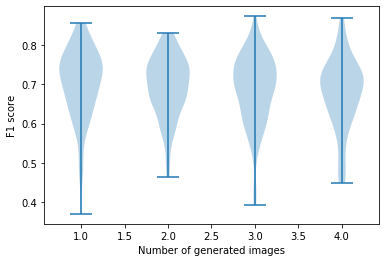

In [3]:
accus1, f1s1 = generateData(1)
accus2, f1s2 = generateData(2)
accus3, f1s3 = generateData(3)
accus4, f1s4 = generateData(4)
plt.xlabel('Number of generated images')
plt.ylabel('F1 score')
plt.violinplot(f1s1 + f1s2 + f1s3 + f1s4)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2341c72fc88>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x2341c72fbe0>,
 'cmins': <matplotlib.collections.LineCollection at 0x2341c73d240>,
 'cbars': <matplotlib.collections.LineCollection at 0x2341c73d940>}

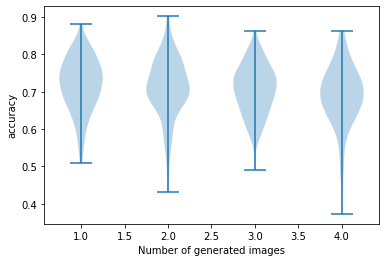

In [4]:
plt.xlabel('Number of generated images')
plt.ylabel('accuracy')
plt.violinplot(accus1 + accus2 + accus3 + accus4)

In [19]:
# print(accus1)
print(statistics.mean(accus1[0]))
print(statistics.median(accus1[0]))
print(statistics.mean(accus2[0]))
print(statistics.median(accus2[0]))
print(statistics.mean(accus3[0]))
print(statistics.median(accus3[0]))
print(statistics.mean(accus4[0]))
print(statistics.median(accus4[0]))

0.71996
0.725
0.71033
0.706
0.70501
0.706
0.69017
0.696


In [21]:
print(statistics.mean(f1s1[0]))
print(statistics.median(f1s1[0]))
print(statistics.mean(f1s2[0]))
print(statistics.median(f1s2[0]))
print(statistics.mean(f1s3[0]))
print(statistics.median(f1s3[0]))
print(statistics.mean(f1s4[0]))
print(statistics.median(f1s4[0]))

0.7030281891813417
0.7232923484850604
0.6951840014693321
0.6996173047897185
0.6873155405922082
0.6988555226011974
0.6771736500369157
0.6960252681614911


In [9]:
def test_algo(images, outputNum):
    imageNum = images.shape[0]
    framePerImg = (imageNum - 1) / (outputNum + 1)
    previousFrame = images[0]
    result = np.zeros([outputNum, images[0].shape[0], images[0].shape[1]])
    for i in range(outputNum):
        currentImg = (i + 1) * framePerImg
        low = images[int(np.floor(currentImg))]
        high = images[int(np.ceil(currentImg))]
#         print(currentImg - np.floor(currentImg))
        currentNew = low + (high - low) * (currentImg - np.floor(currentImg))
        result[i] = currentNew - previousFrame
        previousFrame = currentNew
    return result.astype(int)